In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.utils import algorithm_globals

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

In [ ]:
# fix the random seed for deterministic results
random_seed = 5
np.random.seed(random_seed)
algorithm_globals.random_seed = random_seed

In [ ]:
# read the AqSolDB dataset
filename = 'curated-solubility-dataset.csv'
df = pd.read_csv(filename, sep=',')

# select 300 samples for tutorial purpose
df_subset = df[(df['Group'] == 'G5')][:300]

# pick the first four features and labels from the dataframe
X = df_subset[['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount']].to_numpy()
y = df_subset['Solubility'].to_numpy()
num_feature = 4

In [ ]:
# scale the inputs to range (0, 1) for the input roatational angles in quantum circuits
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

# split the dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.9, random_state=random_seed)

In [ ]:
# define the quantum circuits to construct the kernel matrix
feature_map = ZZFeatureMap(feature_dimension=num_feature, reps=1, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [ ]:
# build and train the prediction model (SVM regressor)
# This step may take a few minutes to run.
svr_qiskit = SVR(kernel=kernel.evaluate).fit(X_train, y_train)

In [ ]:
# validate the model using the testing set
predictions = svr_qiskit.predict(X_test)

r2 = r2_score(y_test, predictions)
corrcoef = np.corrcoef(y_test, predictions)[0][1]
rmse = root_mean_squared_error(y_test, predictions)

print('Qiskit kernel-based SVR')
print(f'r-square: {r2:.3f}')
print(f'correlation coefficient: {corrcoef:.3f}')
print(f'root-mean-square error: {rmse:.3f}')

qiskit kernel-based SVR
r-square: 0.773
correlation coefficient: 0.883
root-mean-square error: 0.799


Text(0, 0.5, 'Predicted solubility')

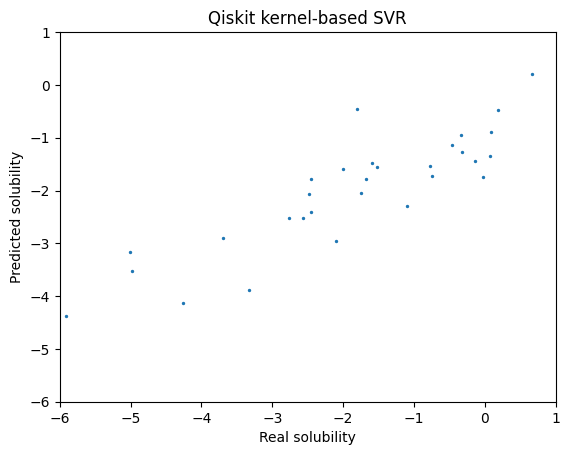

In [ ]:
# draw the scatter plot for testing set to visualize the results
plt.scatter(y_test, predictions, s=2)
max_value = np.ceil(max(np.concatenate((predictions, y_test))))
min_value = np.floor(min(np.concatenate((predictions, y_test))))
plt.title('Qiskit kernel-based SVR')
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.xlabel('Real solubility')
plt.ylabel('Predicted solubility')